In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import re,os
import glob, traceback
import seaborn as sns
import matplotlib.dates as mdates

## 0. Read all csv files

In [7]:
df_2019.head(1)

,id,created_at,text,user_id,name,screen_name,description,DrugAbuse,lang,gender,age,org,date,is_teenage,drug_type,sent_score,sentiment,race
0,1083147454290247680,Wed Jan 09 23:44:11 +0000 2019,USER forever get chill HTTPURL,1008830740308680704,',caprogers1940,-This is the fight of our lives- @holdmyshiel...,1,en,male,<=18,non-org,2020-01-01,1,[],0.0,neu,api


In [4]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2019.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_r = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2019_race.csv')
df_r.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_r = df_r.loc[:, ~df_r.columns.str.match('Unnamed')]

df_2019 = pd.merge(df, df_r[['id', 'user_id', 'race']],  how='left', on=['id','user_id'])
df_2019.shape

df.shape, df_r.shape, df_2019.shape

((2799726, 17), (1811516, 18), (2799726, 18))

In [5]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2020.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_r = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2020_race.csv')
df_r.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_r = df_r.loc[:, ~df_r.columns.str.match('Unnamed')]

df_2020 = pd.merge(df, df_r[['id', 'user_id', 'race']],  how='left', on=['id','user_id'])
df_2020.shape

df.shape, df_r.shape, df_2020.shape

((3502171, 17), (2275943, 18), (3502171, 18))

In [6]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2021.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_r = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2021_race.csv')
df_r.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_r = df_r.loc[:, ~df_r.columns.str.match('Unnamed')]

df_2021 = pd.merge(df, df_r[['id', 'user_id', 'race']],  how='left', on=['id','user_id'])
df_2021.shape

df.shape, df_r.shape, df_2021.shape

((2553235, 17), (1723470, 18), (2553235, 18))

In [8]:
drug_keywords_map= {
'tobacco' : ['nicotine', 'tobacco', 'cigarette', 'cigarrette', 'cigar', 'bidis', 'snuff'],
'alcohol' : ['liquor', 'beer', 'wine'],
'cannabinoids' : ['marijuana', 'blunt', 'dope', 'ganja', 'grass', 'herb', 'joint', 'bud', 'mary jane', 'pot', 'reefer', 'green', 'trees', 'smoke', 'sinsemilla', 'skunk', 'weed','hashish', 'boom', 'gangster', 'hash', 'hash oil', 'hemp'],
'opioids' : ['heroin', 'smack', 'horse', 'brown sugar', 'dope', 
             # 'H',
             'junk', 'skag', 'skunk', 'white horse', 'China white','opium', 'laudanum', 'paregoric', 'big O', 'black stuff', 'block', 'gum', 'hop'],
'stimulants': ['cocaine', 'hydrochloride', 'blow', 'bump',
               # 'C',
                'candy', 'Charlie', 'coke', 'crack', 'flake', 'rock', 'snow', 'toot','amphetamine', 'Biphetamine', 'Dexedrine', 'bennies', 'black beauties', 'crosses', 'hearts', 'LA turnaround', 'speed', 'truck drivers', 'uppers','methamphetamine', 'Desoxyn','meth', 'ice', 'crank', 'chalk', 'crystal', 'fire', 'glass', 'go fast', 'speed'],
'club_drugs':['mdma', 'ecstasy', 'adam', 'clarity', 'eve', "lover's speed", 'peace', 'uppers','flunitrazepam', 'rohypnol', 'forget-me pill', 'mexican valium', 'r2', 'roach', 'roche', 'roffles', 'roofinol', 'rope', 'rophies','ghb', 'Gamma-hydroxybutyrate', 
              # 'G',
              'Georgia home boy', 'grievous bodily harm', 'liquid ecstasy', 'soap', 'scoop', 'goop', 'liquid X'],
'dissociative_drugs':['ketamine', 'Ketalar SV', 'cat Valium',
                      # 'K',
                      'Special K', 'vitamin K','pcp and analogs', 'phencyclidine' 'angel dust', 'boat', 'hog', 'love boat', 'peace pill','salvia divinorum', 'salvia', 'shepherdess’s herb', 'maria pastora', 'magic mint', 'sally-d','dextromethorphan', 'dxm',  'robotripping', 'robo', 'triple'],
'hallucinogens':['lsd','Lysergic acid diethylamide', 'acid', 'blotter', 'cubes', 'microdot', 'yellow sunshine', 'blue heaven', 'mescaline', 'Buttons', 'cactus', 'mesc', 'peyote', 'psilocybin', 'Magic mushrooms', 'purple passion', 'shrooms', 'little smoke'],
'other_compounds':['anabolic_steroids', 'Anadrol', 'Oxandrin', 'Durabolin', 'Depo-Testosterone', 'Equipoise', 'roids', 'juice', 'gym candy', 'pumpers','inhalants', 'Solvents', 'paint thinners', 'gasoline', 'glues', 'gasses', 'butane', 'propane', 'aerosol propellants', 'nitrous oxide',  'nitrites' ,'isoamyl', 'isobutyl', 'cyclohexyl','laughing gas', 'poppers', 'snappers', 'whippets'],
'prescription_medications':['cns_depressants', 'stimulants', 'opioid pain relievers', 'OxyContin','Oxycodone', 'Vicodin', 'Norco', 'Lortab', 'Hydrocodone', 'Acetaminophen', 'Percocet ', 'Oxycodone', 'Acetaminophen','Tramadol','Codeine','Morphine','Methadone','Demerol', 'meperidine','Acetaminophen','Tylenol', 'Excedrin', 'Vanquish','Aspirin', 'Bayer', 'Bufferin', 'Ecotrin', 'Excedrin', 'Vanquish','Diclofenac', 'Voltaren Gel','Ibuprofen', 'Advil', 'Motrin IB','Naproxen', 'Aleve']
}

drug_cols = drug_keywords_map.keys()

In [9]:
# https://nida.nih.gov/sites/default/files/cadchart.pdf
for keyword, words in drug_keywords_map.items():
    pattern = fr'\b(?:{"|".join(words)})\b'
    # print(f'Keyword: {keyword}, Pattern: {pattern}')
    df_2019[keyword] = df_2019['text'].str.contains(pattern, case=False).astype(int)
    df_2020[keyword] = df_2020['text'].str.contains(pattern, case=False).astype(int)
    df_2021[keyword] = df_2021['text'].str.contains(pattern, case=False).astype(int)

In [10]:
drug_cols = list(drug_keywords_map.keys())

In [11]:
df_2019['drug_type'] = df_2019[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2020['drug_type'] = df_2020[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2021['drug_type'] = df_2021[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)

In [12]:
# df_2019['drug_type'].value_counts(), df_2020['drug_type'].value_counts(), df_2021['drug_type'].value_counts()

# 1. Statistical Distribution by demographics

In [13]:
def get_the_agg_results(data, agg_by_user=False, race=False):
    years = [2019, 2020, 2021]
    age_groups = ['<=18','19-29', '30-39', '>=40']
    race_groups = ['api', 'white', 'hispanic', 'black']
    metrics = ['Total Tweets', 'Org', 'Person', 'Female', 'Male', 
           'Teenage', 'Adult', 'Teenage Female', 'Teenage Male', 'Adult Female', 'Adult Male'] + age_groups + ['Neutral', 'Positive', 'Negative']
    if race:
        metrics += race_groups 
    
    results = {metric: [] for metric in metrics}
    for i in range(3):
        dff = data[i]
        year = years[i]
        if agg_by_user:
            dff = dff.drop_duplicates(subset=['user_id'], keep='first')
        is_org = dff[dff['org'] == 'is-org']
        non_org = dff[dff['org'] != 'is-org']

        total_tweets = dff.shape[0]
        count_is_org = is_org.shape[0]
        count_non_org = non_org.shape[0]
        percent_is_org = (count_is_org / total_tweets) * 100
        percent_non_org = (count_non_org / total_tweets) * 100

        total_user_tweets = count_non_org
        total_female_tweets = non_org[non_org['gender'] == 'female'].shape[0]
        total_male_tweets = non_org[non_org['gender'] == 'male'].shape[0]
        percent_female = (total_female_tweets / total_user_tweets) * 100
        percent_male = (total_male_tweets / total_user_tweets) * 100

        total_teenagers_tweets = non_org[non_org['is_teenage'] == 1].shape[0]
        total_adult_tweets = non_org[non_org['is_teenage'] != 1].shape[0]
        percent_teenage = (total_teenagers_tweets / total_user_tweets) * 100
        percent_adult = (total_adult_tweets / total_user_tweets) * 100

        tf = non_org[(non_org['is_teenage'] == 1) & (non_org['gender'] == 'female')].shape[0]
        tm = non_org[(non_org['is_teenage'] == 1) & (non_org['gender'] == 'male')].shape[0]
        af = non_org[(non_org['is_teenage'] != 1) & (non_org['gender'] == 'female')].shape[0]
        am = non_org[(non_org['is_teenage'] != 1) & (non_org['gender'] == 'male')].shape[0]
        percent_tf = (tf / total_user_tweets) * 100
        percent_tm = (tm / total_user_tweets) * 100
        percent_af = (af / total_user_tweets) * 100
        percent_am = (am / total_user_tweets) * 100

        total_neu_tweets = dff[(dff['sentiment'] == 'neu')].shape[0]
        total_pos_tweets = dff[(dff['sentiment'] == 'pos')].shape[0]
        total_neg_tweets = dff[(dff['sentiment'] == 'neg')].shape[0]
        percent_neu = (total_neu_tweets / total_tweets) * 100
        percent_pos = (total_pos_tweets / total_tweets) * 100
        percent_neg = (total_neg_tweets / total_tweets) * 100

        totals = {}
        percentages = {}
        for age_group in age_groups:
            totals[age_group] = non_org[non_org['age'] == age_group].shape[0]
            percentages[age_group] = (totals[age_group] / non_org.shape[0]) * 100

        if race:
            for race in race_groups:
                totals[race] = non_org[non_org['race'] == race].shape[0]
                percentages[race] = (totals[race] / non_org.shape[0]) * 100

        results['Total Tweets'].append(total_tweets)
        results['Org'].append(f"{count_is_org} ({percent_is_org:.2f}%)")
        results['Person'].append(f"{count_non_org} ({percent_non_org:.2f}%)")
        # results['Non Org User Tweets'].append(total_user_tweets)
        results['Female'].append(f"{total_female_tweets} ({percent_female:.2f}%)")
        results['Male'].append(f"{total_male_tweets} ({percent_male:.2f}%)")
        results['Teenage'].append(f"{total_teenagers_tweets} ({percent_teenage:.2f}%)")
        results['Adult'].append(f"{total_adult_tweets} ({percent_adult:.2f}%)")
        results['Teenage Female'].append(f"{tf} ({percent_tf:.2f}%)")
        results['Teenage Male'].append(f"{tm} ({percent_tm:.2f}%)")
        results['Adult Female'].append(f"{af} ({percent_af:.2f}%)")
        results['Adult Male'].append(f"{am} ({percent_am:.2f}%)")

        results['Neutral'].append(f"{total_neu_tweets} ({percent_neu:.2f}%)")
        results['Positive'].append(f"{total_pos_tweets} ({percent_pos:.2f}%)")
        results['Negative'].append(f"{total_neg_tweets} ({percent_neg:.2f}%)")

        for age_group in age_groups:
            results[f"{age_group}"].append(f"{totals[age_group]} ({percentages[age_group]:.2f}%)")

        if race:
            for race in race_groups:
                results[f"{race}"].append(f"{totals[race]} ({percentages[race]:.2f}%)")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results, index=years).T
    # Print the pivoted DataFrame
    # print(results_df)
    return results_df

In [ ]:
results_df = get_the_agg_results([df_2019, df_2020, df_2021], agg_by_user=False, race=True)
print(results_df)
# results_df.to_csv('demo_dist_agg_by_post.csv')

In [ ]:
results_udf = get_the_agg_results([df_2019, df_2020, df_2021], agg_by_user=True, race=True)
print(results_udf)
# results_df.to_csv('demo_dist_agg_by_user.csv')

# 2. Distribution across different drug types

In [16]:
def get_the_dist_of_drugs_results(data, agg_by_user=False, race=False):
    years = [2019, 2020, 2021]
    # Initialize an empty dictionary to collect results
    results_dict = {}
    age_groups = ['<=18','19-29', '30-39', '>=40']
    race_groups = ['api', 'white', 'hispanic', 'black']

    for i in range(3):
        year = years[i]
        dff = data[i]
        if agg_by_user:
            dff = dff.drop_duplicates(subset=['user_id'], keep='first')
        org = dff[dff['org'] == 'is-org']
        non_org = dff[dff['org'] != 'is-org']

        female = non_org[(non_org['gender'] == 'female')]
        male = non_org[(non_org['gender'] == 'male')]
        adult = non_org[(non_org['is_teenage'] == 1)]
        teenage = non_org[(non_org['is_teenage'] != 1)]

        to_value_counts = dff['drug_type'].value_counts()
        to_percentages = (to_value_counts / dff.shape[0]) * 100

        o_value_counts = org['drug_type'].value_counts()
        p_value_counts = non_org['drug_type'].value_counts()
        o_percentages = (o_value_counts / dff.shape[0]) * 100
        p_percentages = (p_value_counts /dff.shape[0]) * 100

        f_value_counts = female['drug_type'].value_counts()
        m_value_counts = male['drug_type'].value_counts()
        f_percentages = (f_value_counts / dff.shape[0]) * 100
        m_percentages = (m_value_counts / dff.shape[0]) * 100

        a_value_counts = adult['drug_type'].value_counts()
        t_value_counts = teenage['drug_type'].value_counts()
        a_percentages = (a_value_counts / dff.shape[0]) * 100
        t_percentages = (t_value_counts / dff.shape[0]) * 100

        value_counts = {}
        percentages = {}
        for age_group in age_groups:
            age_filter = non_org[non_org['age'] == age_group]
            value_counts[age_group] = age_filter['drug_type'].value_counts()
            percentages[age_group] = (value_counts[age_group] / dff.shape[0]) * 100

        if race:
            for race in race_groups:
                race_filter = non_org[non_org['race'] == race]
                value_counts[race] = race_filter['drug_type'].value_counts()
                percentages[race] = (value_counts[race] / non_org.shape[0]) * 100

        # Combine the counts and percentages into a DataFrame
        result = pd.DataFrame({
            f'Total {year}': to_value_counts.astype(int).astype(str) + ' (' + to_percentages.map('{:.2f}%'.format) + ')',        
            f'Org {year}': o_value_counts.astype(int).astype(str) + ' (' + o_percentages.map('{:.2f}%'.format) + ')',        
            f'Person {year}': p_value_counts.astype(int).astype(str) + ' (' + p_percentages.map('{:.2f}%'.format) + ')',        
            f'Female {year}': f_value_counts.astype(int).astype(str) + ' (' + f_percentages.map('{:.2f}%'.format) + ')',
            f'Male {year}': m_value_counts.astype(int).astype(str) + ' (' + m_percentages.map('{:.2f}%'.format) + ')',
            f'Adult {year}': a_value_counts.astype(int).astype(str) + ' (' + a_percentages.map('{:.2f}%'.format) + ')',
            f'Teenage {year}': t_value_counts.astype(int).astype(str) + ' (' + t_percentages.map('{:.2f}%'.format) + ')'
        })

        for age_group in age_groups:
            result[f'{age_group} {year}'] = value_counts[age_group].astype(int).astype(str) + ' (' + percentages[age_group].map('{:.2f}%'.format) + ')'

        if race:
            for race in race_groups:
                result[f'{race} {year}'] = value_counts[race].astype(int).astype(str) + ' (' + percentages[race].map('{:.2f}%'.format) + ')'
       
        # Fill NaN values with 0 for better readability
        result = result.fillna('0 (0.00%)')

        # Add the result to the dictionary
        results_dict[year] = result

    # Concatenate all results along columns
    combined_result = pd.concat(results_dict.values(), axis=1)

    # Prepare multi-index for columns
    columns = pd.MultiIndex.from_product([combined_result.index, years], names=['Drug', 'Year'])
    
    # Reorganize the DataFrame to have drug types as columns and two rows for male and female
    groups = ['Total', 'Org', 'Person', 'Female', 'Male', 'Adult', 'Teenage'] + age_groups + race_groups
    final_result = pd.DataFrame(index= groups, columns=columns)

    for drug_type in combined_result.index:
        for year in years:
            final_result[(drug_type, year)] = [

                combined_result.at[drug_type, f'Total {year}'],
                combined_result.at[drug_type, f'Org {year}'],
                combined_result.at[drug_type, f'Person {year}'],
                combined_result.at[drug_type, f'Female {year}'],
                combined_result.at[drug_type, f'Male {year}'],
                combined_result.at[drug_type, f'Teenage {year}'],
                combined_result.at[drug_type, f'Adult {year}'],
                combined_result.at[drug_type, f'<=18 {year}'],
                combined_result.at[drug_type, f'19-29 {year}'],
                combined_result.at[drug_type, f'30-39 {year}'],
                combined_result.at[drug_type, f'>=40 {year}'],
                combined_result.at[drug_type, f'api {year}'],
                combined_result.at[drug_type, f'white {year}'],
                combined_result.at[drug_type, f'black {year}'],
                combined_result.at[drug_type, f'hispanic {year}'],
                # combined_result.at[drug_type, f'Total {year}'],
            ]

    return final_result

In [17]:
final_results= get_the_dist_of_drugs_results([df_2019, df_2020, df_2021], agg_by_user = False, race = True)
# final_results.to_csv('drug_demo_dist_by_post.csv')
# df=results_dict[2020].T
# df.to_csv('2020_by_demo_drug.csv')
# df=results_dict[2019].T
# df.to_csv('2019_by_demo_drug.csv')
# df=results_dict[2021].T
# df.to_csv('2021_by_demo_drug.csv')

In [ ]:
final_results

In [15]:
final_results= get_the_dist_of_drugs_results([df_2019, df_2020, df_2021], agg_by_user = True, race = True)
# final_results.to_csv('drug_demo_dist_by_user.csv')

In [ ]:
# results_dict = {}
# result = pd.DataFrame({
#     '2019': df_2019['drug_type'].value_counts(),
#     '2020': df_2020['drug_type'].value_counts(),
#     '2021':  df_2021['drug_type'].value_counts()
#     })
# results_dict['drug_type'] = result
# result = pd.DataFrame({
#     '2019': df_2019['race'].value_counts(),
#     '2020': df_2020['race'].value_counts(),
#     '2021':  df_2021['race'].value_counts()
#     })
# results_dict['race'] = result
# combined_result = pd.concat(results_dict.values(), axis=0) #axis=1
# combined_result

## 3. Quartly Trend Analysis

In [19]:
data= pd.concat([df_2019, df_2020, df_2021], ignore_index=True)

In [20]:
data['created_at'] = pd.to_datetime(data['created_at'], format='%a %b %d %H:%M:%S %z %Y')

In [21]:
data['quarter'] = data['created_at'].dt.to_period('Q')
data['month'] = data['created_at'].dt.to_period('M')

/tmp/ipykernel_64461/1706348614.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['quarter'] = data['created_at'].dt.to_period('Q')
/tmp/ipykernel_64461/1706348614.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['month'] = data['created_at'].dt.to_period('M')


In [22]:
data['week'] = data['created_at'].dt.to_period('W')

/tmp/ipykernel_64461/3355642356.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['week'] = data['created_at'].dt.to_period('W')


In [23]:
def calculate_percentages(data, period, category_col, categories, drug_type=None):
    if drug_type:
        sub_data = data[data['drug_type']==drug_type]
        df = sub_data[[period, category_col]]
    else:   
        df = data[[period, category_col]]
            
    g = df.groupby([period, category_col]).size().unstack(fill_value=0).reset_index()
    g['total'] = data.groupby([period]).size().reset_index(name='Count')['Count']
    g['all'] = g[categories].sum(axis=1)
    g['all_pct'] = (g['all'] / g['total']) * 100
    for cat in categories:
        g[cat + '_pct'] = (g[cat] / g['total']) * 100
    return g

def calculate_ratio(data, period, category_col, categories, drug_type=None):
    if drug_type:
        sub_data = data[data['drug_type']==drug_type]
        df = sub_data[[period, category_col]]
        user_data = sub_data.drop_duplicates(subset=['user_id'], keep='first')
    else:   
        df = data[[period, category_col]]
        user_data = data.drop_duplicates(subset=['user_id'], keep='first')
            
    g = df.groupby([period, category_col]).size().unstack(fill_value=0).reset_index()
    g['total'] = data.groupby([period]).size().reset_index(name='Count')['Count']
    g['all'] = g[categories].sum(axis=1)
    g['all_pct'] = (g['all'] / g['total']) * 100
    for cat in categories:
        g[cat + '_pct'] = (g[cat] / g['total']) * 100
        
    u_g = user_data[[period, category_col]]
    u_g = u_g.groupby([period, category_col]).size().unstack(fill_value=0).reset_index()
    u_g['all'] = u_g[categories].sum(axis=1)
    u_g['all_pct'] = g['all'] / u_g['all']
    for cat in categories:
        u_g[cat+'_pct'] = g[cat]/u_g[cat] # renaming _pct for now "change it to _ratio"
    return u_g

def prepare_grouped_data(data, period, columns, drug_type=None, user_ratio =False):
    groups = {
        'age_groups': ['<=18', '19-29', '30-39', '>=40'],
        'gender_types': ['male', 'female'],
        'user_types': ['is-org', 'non-org'],
        'sentiment_types': ['neu', 'pos', 'neg'],
        'race_groups': ['api', 'white', 'hispanic', 'black'],
        # 'teen_adult': ['1', '0']
    }
    
    if user_ratio:
        grouped_data = {
            'age_g': calculate_ratio(data, period, 'age', groups['age_groups'], drug_type),
            'gender_g': calculate_ratio(data, period, 'gender', groups['gender_types'], drug_type),
            'user_g': calculate_ratio(data, period, 'org', groups['user_types'], drug_type),
            'sentiment_g': calculate_ratio(data, period, 'sentiment', groups['sentiment_types'], drug_type),
            'race_g': calculate_ratio(data, period, 'race', groups['race_groups'], drug_type),
            # 'teen_adult_g': calculate_ratio(data, period, 'is_teenage', groups['teen_adult'], drug_type)
        }
    else:
        grouped_data = {
            'age_g': calculate_percentages(data, period, 'age', groups['age_groups'], drug_type),
            'gender_g': calculate_percentages(data, period, 'gender', groups['gender_types'], drug_type),
            'user_g': calculate_percentages(data, period, 'org', groups['user_types'], drug_type),
            'sentiment_g': calculate_percentages(data, period, 'sentiment', groups['sentiment_types'], drug_type),
            'race_g': calculate_percentages(data, period, 'race', groups['race_groups'], drug_type),
            # 'teen_adult_g': calculate_percentages(data, period, 'is_teenage', groups['teen_adult'], drug_type)
        }
    return groups, grouped_data

In [24]:
def plot_trend(groups, grouped_df, period, category, ax, drug_type=None):
    colors = ['blue', 'green', 'red', 'black']
    markers = ['^', 's', 'o', '*']
    s = 50 if period == 'month' else 100
    label = {'is-org': 'Org', 'non-org': 'Person',
             'neu': 'Neutral', 'pos': 'Positive', 'neg': 'Negative',
             'api':'API', 'white': 'White', 'hispanic': 'Hispanic', 'black':'Black',
             'male':'Male', 'female':'Female'
            }
    if groups:
        for i in range(len(groups)):
            a = groups[i]
            c = colors[i]
            m = markers[i]
            ax.plot(grouped_df[period].index, grouped_df[a + '_pct'], color=c)
            ax.scatter(grouped_df[period].index, grouped_df[a + '_pct'], marker=m, s=s, color=c, label= label[a] if a in label.keys() else a)
    else:
        ax.plot(grouped_df[period].index, grouped_df['all_pct'], color='Orange')
        ax.scatter(grouped_df[period].index, grouped_df['all_pct'], marker='D', s=s, color='Orange', label='all posts')
  
    tick_positions = [-1, 3, 7, 11]
    tick_labels = ['2019Q1', '2020Q1', '2021Q1', '2022Q1']
    if period == 'month':
        tick_positions = [-1, 5, 11, 17, 23, 29, 35]
        tick_labels = ['2019-01', '2019-06', '2020-01', '2020-06', '2021-01', '2021-06', '2022-01']
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel('Quarter' if period=='quarter' else 'Month', fontsize=12)
    ax.set_ylabel('Percentage', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(False)
    
    # ax.axvspan(3,5, color='blue', alpha=0.2)  # Adjust alpha for transparency
    start = 4 if period =='quarter' else 14
    xlim = ax.get_xlim()
    ax.axvline(start, color='gray', linestyle='--', linewidth=1.5)

In [25]:
def plot_all_trends(groups, grouped_data, period, main_title, filename, drug_type=None):
    fig, axs = plt.subplots(3, 2, figsize=(15, 18))  # Adjust the grid size (3x2) and figure size as needed
    axs = axs.flatten()

    params = [(None, grouped_data['user_g'], 'Default')] if drug_type else []
    # List of parameters for each plot
    params += [
        (groups['user_types'], grouped_data['user_g'], 'User Type'),
        (groups['age_groups'], grouped_data['age_g'], 'Age Group'),
        (groups['gender_types'], grouped_data['gender_g'], 'Gender'),
        (groups['race_groups'], grouped_data['race_g'], 'Race'),
        (groups['sentiment_types'], grouped_data['sentiment_g'], 'Sentiment')
    ]

    # Plot each trend on a different subplot
    for i, (group, grouped_df, category) in enumerate(params):
        plot_trend(group, grouped_df, period, category, axs[i], drug_type)
        axs[i].set_title(f'Trend by {category}', fontsize=12)  # Individual subplot titles

    # Remove any empty subplots if there are fewer plots than subplots
    for j in range(len(params), len(axs)):
        fig.delaxes(axs[j])

    plt.subplots_adjust(top=0.95)  
    fig.suptitle(main_title, fontsize=16)

    # plt.savefig(filename+'_combined_plots.png', bbox_inches='tight')
    plt.show()

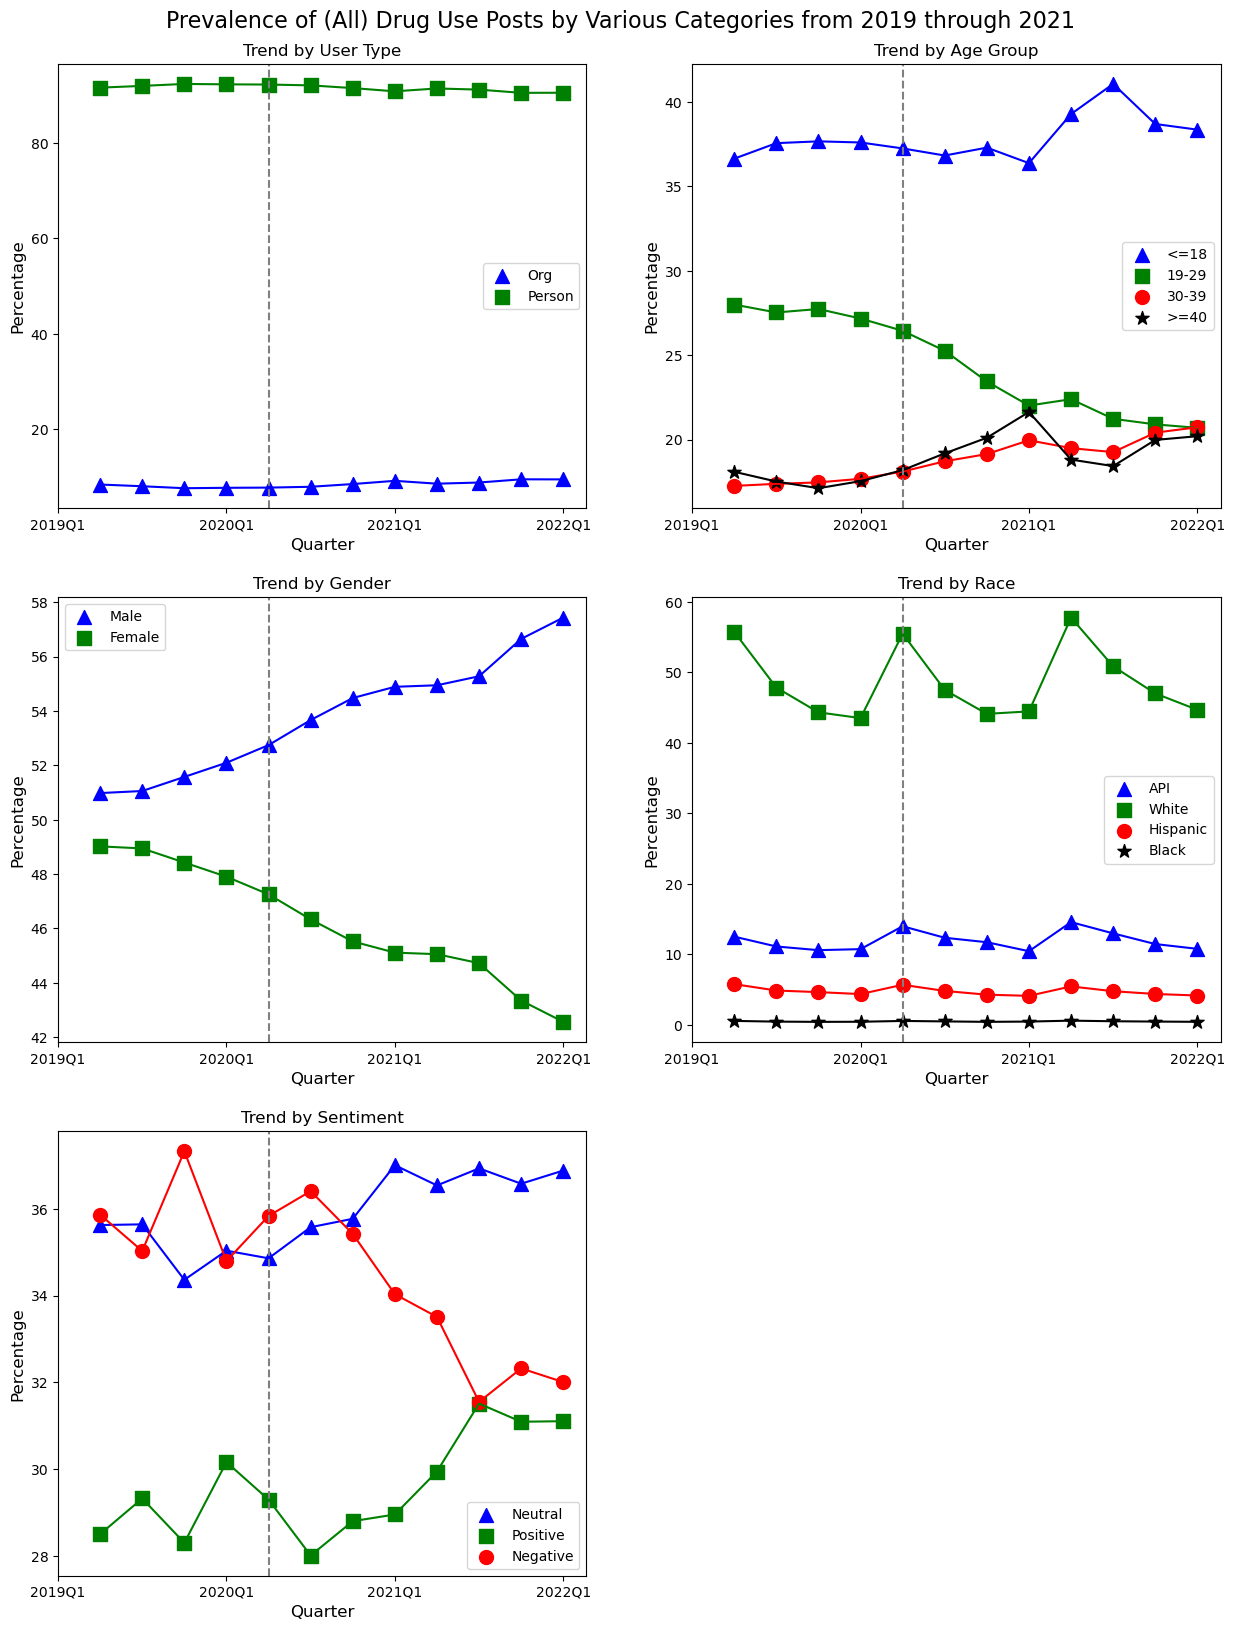

In [26]:
# Main logic
period = 'quarter'
groups, grouped_data = prepare_grouped_data(data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], None)
main_title = "Prevalence of (All) Drug Use Posts by Various Categories from 2019 through 2021"
plot_all_trends(groups, grouped_data, period, main_title, 'All')

In [ ]:
period = 'quarter'
user_data = data.drop_duplicates(subset=['user_id'], keep='first')
groups, grouped_data = prepare_grouped_data(user_data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], None)
main_title = "Prevalence of (All) Drug Users by Various Categories from 2019 through 2021"
plot_all_trends(groups, grouped_data, period, main_title, 'All_users')

In [27]:
drugs_map = {
            'tobacco' :'Tobacco',
            'alcohol' : 'Alcohol',
            'cannabinoids' : 'Cannabinoids',
            'opioids' : 'Opioids',
            'stimulants' : 'Stimulants',
            'club_drugs' : 'Club Drugs',
            'dissociative_drugs': 'Dissociative Drugs',
            'hallucinogens' : 'Hallucinogens',
            'other_compounds' : 'Other Compounds',
            'prescription_medications' : 'Prescription Medications'
}

## 4. Trend in drug types

In [ ]:
# by post
for i, drug in enumerate(drug_cols):
    period = 'month'
    groups, grouped_data = prepare_grouped_data(data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], drug)
    main_title = f'{drugs_map[drug]}: Prevalence of Drug Use Posts by Various Categories from 2019 through 2021'
    plot_all_trends(groups, grouped_data, period, main_title, f'{i}_{drug}', drug)
    # break
# grouped_data

In [ ]:
# by user
for i, drug in enumerate(drug_cols):
    period = 'month'
    user_data = data.drop_duplicates(subset=['user_id'], keep='first')
    groups, grouped_data = prepare_grouped_data(user_data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], drug)
    main_title = f'{drugs_map[drug]}: Prevalence of Drug Users by Various Categories from 2019 through 2021'
    plot_all_trends(groups, grouped_data, period, main_title, f'{i}_{drug}_user', drug)
    #break

In [ ]:
# Post and User Ratio
for i, drug in enumerate(drug_cols):
    period = 'month'
    user_data = data.drop_duplicates(subset=['user_id'], keep='first')
    groups, grouped_data = prepare_grouped_data(user_data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], drug, user_ratio=True)
    main_title = f'{drugs_map[drug]}: Ratio of Drug Use Posts Per User by Various Categories from 2019 through 2021'
    plot_all_trends(groups, grouped_data, period, main_title, f'{i}_{drug}_user', drug)
    # break
# grouped_data

In [30]:
def plot_single_plot(data, period, ax, handles, labels, name):
    colors = ['red', 'green', 'blue', 'black', 'orange', 'teal', 'pink', 'purple', 'brown', 'gray', 'Magenta']
    for i,d in enumerate(drug_cols):
        c = colors[i]
        sub_data = data[data['drug_type']==d]
        _, df = prepare_grouped_data(sub_data, period, ['age', 'gender', 'org', 'sentiment', 'race', 'is_teenage'], d)
        line, = ax.plot(df['gender_g'][period].index, df['gender_g']['all'], color= c, label= d)
        handles.append(line)
        labels.append(d)
        
    tick_positions = [-1, 3, 7, 11]
    tick_labels = ['2019Q1', '2020Q1', '2021Q1', '2022Q1']
    if period == 'month' :
        tick_positions = [-1, 5, 11, 17, 23, 29, 35]
        tick_labels = ['2019-01', '2019-06', '2020-01', '2020-06', '2021-01', '2021-06', '2022-01']
    elif period =='week' :
        tick_positions = [-1, 25, 50, 75, 100, 125, 150]
        tick_labels = ['2019-01', '2019-06', '2020-01', '2020-06', '2021-01', '2021-06', '2022-01']
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel(f'Number of {name}s', fontsize=12)
    ax.legend(fontsize=6)
    ax.grid(False)

    start = 60 if period =='week' else 14 
    xlim = ax.get_xlim()
    ax.axvline(start, color='gray', linestyle='--', linewidth=1.5)

In [40]:
def plot_drug_distributions(data, period):
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # Adjust the grid size (3x2) and figure size as needed
    axs = axs.flatten()
    
    user_data = data.drop_duplicates(subset=['user_id'], keep='first')
    handles = []
    labels = []
    for i,d in enumerate([data, user_data]):
        name = 'Post' if i ==0 else 'User'
        plot_single_plot(d, period, axs[i], handles, labels, name)
        axs[i].set_title(f'By {name}', fontsize=12) 

    for j in range(2, len(axs)):
        fig.delaxes(axs[j])

    plt.subplots_adjust(wspace=0.6,hspace=0.2, top=0.90)  
    fig.suptitle("Weekly Drug Use Distribution", fontsize=16, fontweight='bold')
    # fig.legend(handles[:10], labels[:10], loc='center right', bbox_to_anchor=(0.9, 0.4), ncol=1, fontsize=8)
    # plt.savefig(period+'_post_user_distribution.png', bbox_inches='tight')
    plt.show()
 

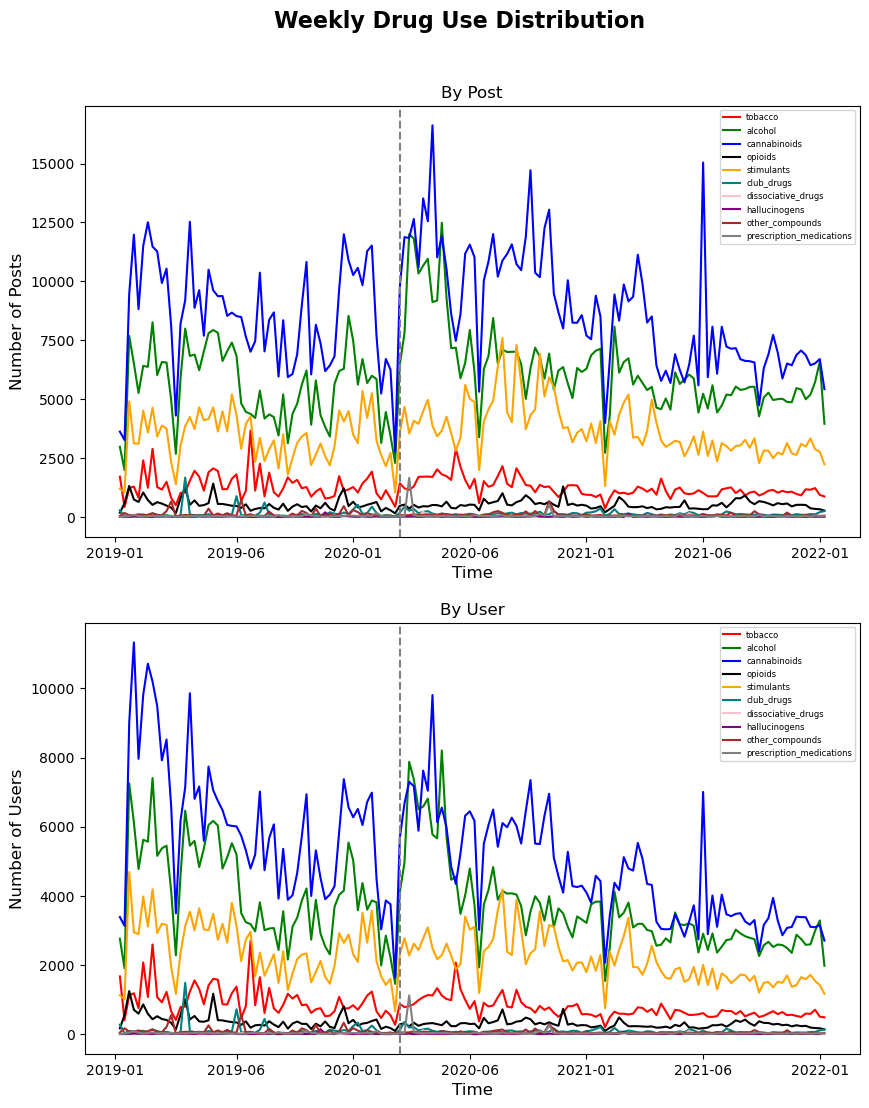

In [41]:
plot_drug_distributions(data, 'week')